<a href="https://colab.research.google.com/github/ujs/PORTFOLIO/blob/master/CIFAR10_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
The CIFAR-10 dataset consists of 60,000 images. Each image has 32*32 pixels and 3 colour channels. There are 10 classes, 6000 images per class. There are 50000 training images and 10000 test images. The goal of this project is to use convolutional neural networks to predict the labels of previously unseen images. I use VGG-3 as the baseline with some regularization, dropout and batch normalization.

In [46]:
!pip install tensorflow==1.14.0

     |████████████████████████████████| 109.2MB 84kB/s 
     |████████████████████████████████| 491kB 43.5MB/s 
     |████████████████████████████████| 3.2MB 46.9MB/s 
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc2


# Step 1- Import Necessary Libraries

In [1]:
#Importing libraries
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from keras import layers
from keras import models
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras import regularizers

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

# Step 2- Importing and Loading the Dataset

In [2]:
#importing data
from keras.datasets import cifar10

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del x, y
   del x_test, y_test
   print('Clear previously loaded data.')
except:
   pass

#load data
(x, y),(x_test, y_test) = cifar10.load_data()



# As a sanity check, print out the size of the training and test data.
print('Training data shape: ', x.shape)
print('Training labels shape: ', y.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)


# Step 3- Data Visualization

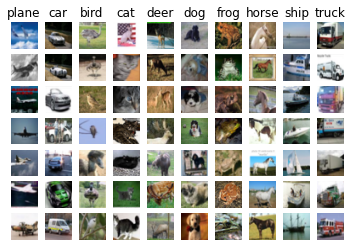

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for i, cls in enumerate(classes):
    idxs = np.flatnonzero(y == i)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for j, idx in enumerate(idxs):
        plt_idx = j * num_classes + i + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x[idx].astype('uint8'))
        plt.axis('off')
        if j == 0:
            plt.title(cls)
plt.show()

# Step 4- Splitting Data into Train, Validation and Test sets

In [4]:
#Splitting x,y data into train and validation data
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=1)

print(x_train.shape)
print(x_val.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)


# Step 5- Data Preprocessing (rescaling, vectorization and augmentation)

In [0]:
#Data Preprocessing

#Rescaling image pixels
x_train = x_train.astype('float32')/255.0
x_val = x_val.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

#One Hot Encoding of Categorical labels
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)



In [0]:
#Data Augmentation
train_datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = train_datagen.flow(x_train,y_train, batch_size = 64)

# Step 6- Defining the Model (Architecture and Compilation)

In [7]:
#Model Definition
def model_cifar10():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation ='relu', kernel_initializer='he_uniform', padding = 'same', input_shape=(32, 32, 3)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(10, activation='softmax'))
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

model = model_cifar10()
model.summary()








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0       

# Step 7- Model Fitting

In [0]:
#Fit the model 

steps = int(x_train.shape[0]/64)
history = model.fit_generator(train_generator, steps_per_epoch = steps, epochs = 200, validation_data = (x_val, y_val))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/200
625/625 [==============================] - 485s 776ms/step - loss: 1.8839 - acc: 0.3490 - val_loss: 1.5913 - val_acc: 0.4411
Epoch 2/200
625/625 [==============================] - 476s 762ms/step - loss: 1.4823 - acc: 0.4606 - val_loss: 1.3055 - val_acc: 0.5285
Epoch 3/200
625/625 [==============================] - 475s 760ms/step - loss: 1.3549 - acc: 0.5123 - val_loss: 1.2676 - val_acc: 0.5476
Epoch 4/200
625/625 [==============================] - 476s 762ms/step - loss: 1.2619 - acc: 0.5451 - val_loss: 1.2591 - val_acc: 0.5455
Epoch 5/200
625/625 [==============================] - 474s 759ms/step - loss: 1.1989 - acc: 0.5711 - val_loss: 1.2740 - val_acc: 0.5477
Epoch 6/200
625/625 [==============================] - 476s 762ms/step - loss: 1.1497 - acc: 0.5885 - val_loss: 1.1166 - val_acc: 0.5996
Epoch 7/200
590/625 [===========================>..] - ETA: 24s - loss: 1.1051 - acc

# Step 8- Plotting Results (loss and accuracy)

In [0]:
#Visualizing model performance

#Plot loss
  plt.subplot(211)
  plt.title('cross-entropy loss')
  plt.plot(history.history['loss'],color = 'blue', label = 'train')
  plt.plot(history.history['val_loss'], color = 'red', label = 'validation')
  plt.legend()

  #plot accurcay
  plt.subplot(212)
  plt.title('accuracy')
  plt.plot(history.history['acc'],color = 'blue', label = 'train')
  plt.plot(history.history['val_acc'], color = 'red', label = 'validation')
  plt.legend()


# Step 9- Evaluating Model Performance on the Test data

In [0]:
#Model Evaluation
results = model.evaluate(x_test, y_test)
print(results)